In [1]:
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle
import lasso
import training_tools

from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Dropout, Activation, Concatenate
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [2]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 
peaks['score'] = np.log(peaks['k27act'] + 1)

# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))
num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))
num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


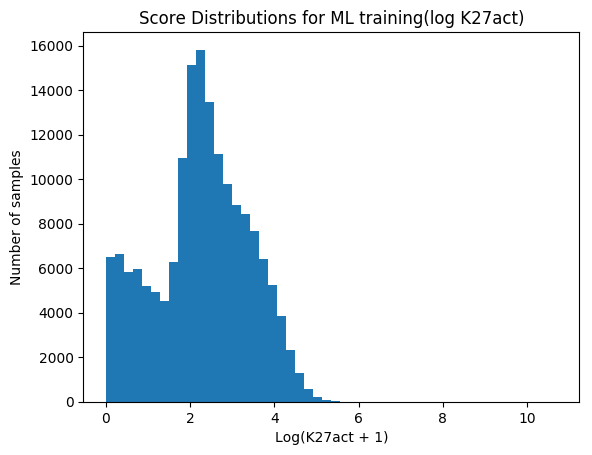

In [3]:
plt.hist(peaks['score'], bins=50)
plt.title('Score Distributions for ML training(log K27act)')
plt.ylabel('Number of samples')
plt.xlabel('Log(K27act + 1)')
plt.show()

In [4]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_counts_pwm_noatac')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

print(out_path)

/home/kal/K27act_models/convolution_model/20180731_162339_counts_pwm_noatac


In [5]:
# model's input
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
num_outputs=1

#build custom functions
def add_RC(x):
    return K.concatenate([x, x[:, ::-1, ::-1]], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

# add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
conv = Conv1D(256, 16, name='conv_in', padding='same', activation=None)(add_rc(seqs))
conv_dropped = SpatialDropout1D(0.1)(conv)
combined = Dense(64, activation='relu')(conv_dropped)
fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(combined)

# then use a dense to get one 'k27ness' per input base
per_base = Dense(num_outputs)(fr_conv)
# sum the k27ness and take the max of forward or reverse
predictions = Lambda(lambda x: K.sum(x, axis=1), name='sum_seq', 
                     output_shape=lambda s: (s[0], 1))(per_base)

#get gradients for lasso
grads = K.gradients(predictions, seqs)[0]

# build the model
model = Model(inputs=seqs, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_seqs (InputLayer)      (32, 1024, 4)             0         
_________________________________________________________________
add_rc (Lambda)              (64, 1024, 4)             0         
_________________________________________________________________
conv_in (Conv1D)             (64, 1024, 256)           16640     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (64, 1024, 256)           0         
_________________________________________________________________
dense_1 (Dense)              (64, 1024, 64)            16448     
_________________________________________________________________
stack_fr (Lambda)            (32, 1024, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (32, 1024, 1)             129       
__________

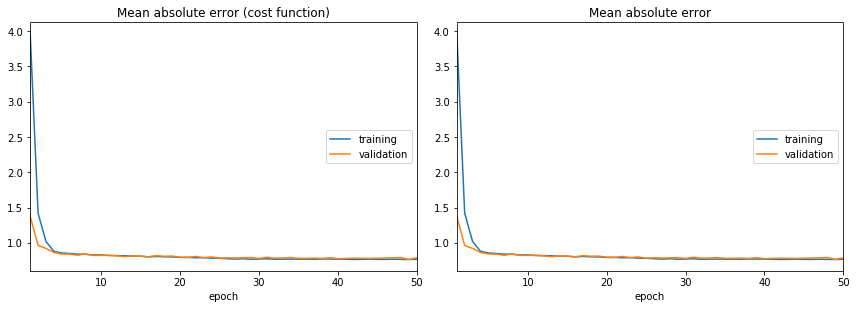

In [6]:
from keras.optimizers import RMSprop, SGD, Adam
from livelossplot import PlotLossesKeras

import training_tools
%matplotlib inline

vpe = 5 # validations per epoch

opt = Adam(lr=1e-04)
model.compile(loss='mean_absolute_error', metrics=['mean_absolute_error'], optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-1-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train', atac=False), 
                             steps_per_epoch=num_training_samples//(batch_size*vpe), 
                             epochs=10*vpe, callbacks=[early_stop, checkpoint, PlotLossesKeras(), 
                                                     training_tools.ChangeLR([0, 5*vpe], [1e-04, 1e-05])], 
                             validation_data=datagen.batch_gen(peaks, mode='val', atac=False), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)
val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

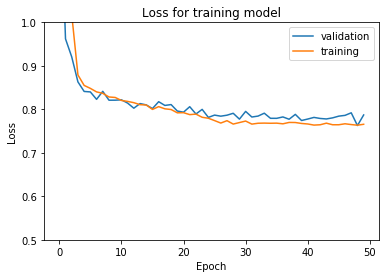

In [7]:
# look at loss
val_hist = np.asarray(val_hist).flatten()
train_hist = np.asarray(train_hist).flatten()
plt.plot(val_hist, label='validation')
plt.plot(train_hist, label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(.5, 1)
plt.legend()
plt.show()

In [8]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [9]:
# write out history
losses=dict()
losses['val_loss'] = val_hist
losses['loss'] = train_hist
pickle.dump(losses, open(os.path.join(history_path, 'history.pk'), 'wb'))

dict_keys(['spatial_dropout1d_1', 'conv_in', 'input_seqs', 'add_rc', 'dense_2', 'sum_seq', 'dense_1', 'stack_fr'])


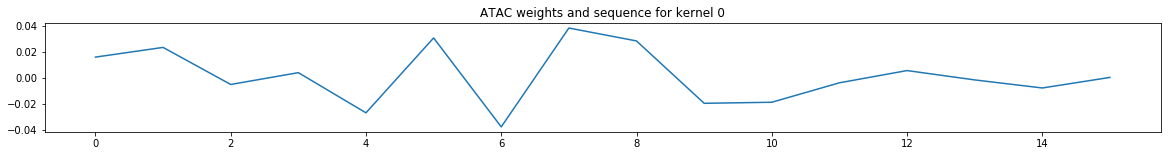

AssertionError: 

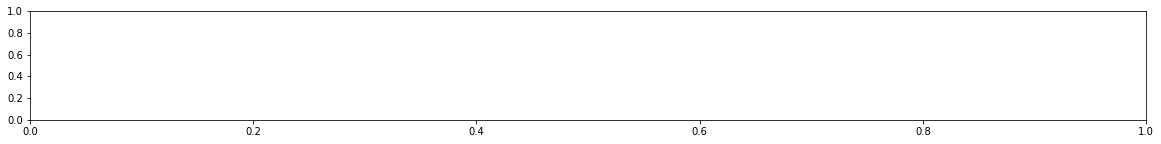

In [10]:
# look at kernels
# make a highlight map
from colour import Color

#what layers do we have to work with?
layer_dict = dict([(layer.name, layer) for layer in model.layers]) 
print(layer_dict.keys())
this_layer='conv_in'

# plot weights from first layer neurons
#temp = .005
weight_array = layer_dict[this_layer].get_weights()[0]
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("white"), 50))
[colors.append(c) for c in (Color("white").range_to(Color("red"), 51))]
top = np.amax(weight_array[:, 0, :])
bottom = np.amin(weight_array[:, 0, :])
    
# got throught the kernels
for idx in range(weight_array.shape[2]):
    weight = weight_array[:,:,idx]
    #get hightlights!
    color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
    highlight=dict()
    for i in range(len(weight)):
        w = color_weights[i]
        highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
    #plot things out
    kernel = sequence.Sequence(weight[:, 1:])
    plt.figure(figsize=(20,2))
    plt.title('ATAC weights and sequence for kernel {}'.format(idx))
    plt.plot(weight[:,0])
    plt.show()
    viz_sequence.plot_weights(kernel.seq, highlight=highlight)


In [ ]:
datagen.batch_gen(peaks, mode='val')